# **SVM을 이용한 뉴스 Topic 분류기**
뉴스 데이터를 활용하여 주제를 구분하는 모델을 만든다
1. **Tf-IDF**
1. **SVM**

<br>
## **1 스펨메일을 활용한 Tf-Idf를 정의한다**
1. Naive Bayse 에서 실습한 분류기 학습을 복습한다
1. 텍스트 데이터 **임베딩을 Tf-Idf** 로 생성한다
1. 앞의 **Smoothing / Naive Bayse** 보다, **Tf-IDF / Naive Bayse** 의 AUC가 더 큼을 알 수 있다.

<br>
### **01 Naive Bayse 내용의 복습**
앞에서 진행한 파일 불러오기 및 전처리 작업을 진행합니다

In [2]:
# 앞에서 진행한 내용 복습
# 정상매일은 0, 스펨매일은 1
import glob,os

emails, labels = [], []
for no, file_path in enumerate(['./data/enron1/ham/','./data/enron1/spam/']):
    for filename in glob.glob(os.path.join(file_path, '*.txt')):
        with open(filename, 'r', encoding = "ISO-8859-1") as infile:
            emails.append(infile.read())
            labels.append(no)

In [3]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer


In [4]:
def letters_only(astr):
    for c in astr:
        if not c.isalpha():
            return False
    return True

def clean_text(docs):
    cleaned_docs = []
    for doc in docs:
        cleaned_docs.append(' '.join([lemmatizer.lemmatize(word.lower())
                                      for word in doc.split()
                      if letters_only(word) and word not in all_names]))
    return cleaned_docs

all_names      = set(names.words())
lemmatizer     = WordNetLemmatizer()
cleaned_emails = clean_text(emails)

In [5]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

k                 = 10
k_fold            = StratifiedKFold(n_splits=k)
cleaned_emails_np = np.array(cleaned_emails)
labels_np         = np.array(labels)

smoothing_factor_option = [1.0, 2.0, 3.0, 4.0, 5.0]

In [6]:
from collections import defaultdict
auc_record = defaultdict(float)

<br>
### **02 Tf-IDf 객체를 생성한다**
1. Naive Bayse 에서 실습한 분류기 학습을 복습한다
1. 이를 활용하여 Tf-Idf 를 생성해본다

In [7]:
%timeit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

for train_indices, test_indices in k_fold.split(cleaned_emails, labels):
    X_train, X_test  = cleaned_emails_np[train_indices], cleaned_emails_np[test_indices]
    Y_train, Y_test  = labels_np[train_indices], labels_np[test_indices]
    tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', max_features=8000)
    term_docs_train  = tfidf_vectorizer.fit_transform(X_train)
    term_docs_test   = tfidf_vectorizer.transform(X_test)
    for smoothing_factor in smoothing_factor_option:
        clf = MultinomialNB(alpha=smoothing_factor, fit_prior=True)
        clf.fit(term_docs_train, Y_train)
        prediction_prob = clf.predict_proba(term_docs_test)
        pos_prob        = prediction_prob[:, 1]
        auc             = roc_auc_score(Y_test, pos_prob)
        auc_record[smoothing_factor] += auc

In [8]:
from pprint import pprint
pprint(auc_record)

defaultdict(<class 'float'>,
            {1.0: 9.936451496663112,
             2.0: 9.944332721241558,
             3.0: 9.949654316234254,
             4.0: 9.953068949176636,
             5.0: 9.954994323342417})


In [11]:
print('max features  smoothing  fit prior  auc')
for smoothing, smoothing_record in auc_record.items():
        print('\t8000 \t {0} \t true \t {1:.4f}'.format(smoothing, smoothing_record/k))

max features  smoothing  fit prior  auc
	8000 	 1.0 	 true 	 0.9936
	8000 	 2.0 	 true 	 0.9944
	8000 	 3.0 	 true 	 0.9950
	8000 	 4.0 	 true 	 0.9953
	8000 	 5.0 	 true 	 0.9955


<br>
## **2 SVM 개념**
1. 최적의 **Hyperplane (데이터가 잘 구분된 최적의 공간)** 을 찾는다
1. 이를 구분하는 데이터 포인트 들을 **Support Vectors**라고 한다

<img src="https://cdn-images-1.medium.com/max/1600/1*7pS12cmdNItZoDVJpc5iGw.png" align="left" width=200>

<br>
### **01 SVM의 원리**
1. 시나리오1 : **Hyperplane**로 데이터 선별  **ex) $wx + b > 0$ , $wx + b < 0$** 로 분할
1. 시나리오2 : 최적의 **Hyperplane** 결정
1. 시나리오3 : **Outlier(이상치)** 처리 - 에러값이 최소가 되게끔 해야 한다

<br>
### **02-1 2개 Topic을 구분하는 SVM (전처리)**
1. 특정한 뉴스토픽 데이터를 불러온 뒤
1. 테스트 데이터를 전처리 작업 후
1. Tf-IDf 로 임베딩 한다

In [14]:
# 구분할 2개의 카테고리 데이터를 불러온다
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.graphics', 'sci.space']
data_train = fetch_20newsgroups(subset='train', categories=categories, random_state=42)
data_test  = fetch_20newsgroups(subset='test',  categories=categories, random_state=42)

In [15]:
# 불러온 데이터들을 전처리 작업한다
cleaned_train = clean_text(data_train.data)
label_train   = data_train.target
cleaned_test  = clean_text(data_test.data)
label_test    = data_test.target

In [19]:
# 개별 뉴스그룹내 비슷한 분포로 0, 1 데이터가 분포되어 있다
from collections import Counter
print('훈련 데이터  : {} \n테스트 데이터 : {}'.format(
    Counter(label_train), Counter(label_test)))

훈련 데이터  : Counter({1: 593, 0: 584}) 
테스트 데이터 : Counter({1: 394, 0: 389})


In [20]:
# 데이터를 Tf-IDF 로 임베딩 변환한다
tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, 
                                   max_df = 0.5, 
                                   stop_words = 'english', 
                                   max_features = 8000)
term_docs_train  = tfidf_vectorizer.fit_transform(cleaned_train)
term_docs_test   = tfidf_vectorizer.transform(cleaned_test)

<br>
### **02-2 2개 Topic을 구분하는 SVM (학습)**
1. Kernal 파라미터는 **Linear**로 설정
1. 패널티 값은 1로 설정
1. SVM 알고리즘 모델을 초기화 한다

In [21]:
# 위에서 정의한 파라미터로 모델을 학습한다
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(term_docs_train, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
# 학습한 모델을 활용하여 데이터를 예측해본다
accuracy = svm.score(term_docs_test, label_test)
print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

The accuracy on testing set is: 96.4%


<br>
### **03 여러개 Topic을 구분하는 SVM**
1. **다중 클래스를** 분류하는 모델
1. **K-클래스의** 문제를 **K개의 서로다른 분류기를** 생성한다
1. **일대 일 방법**은 전체 중 **일부를 사용하여** 컴퓨팅 속도등이 빠르다
1. **일대 다 방법**은 **전체 데이터를** 사용하여 **서로 다른 모듈을** 만든다

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0950705115000520-gr2.jpg" align="left" width=200>

In [24]:
# 다양한 클래스의 뉴스데이터 불러오기
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
    'rec.sport.hockey']

data_train = fetch_20newsgroups(subset='train', categories=categories, random_state=42)
data_test  = fetch_20newsgroups(subset='test',  categories=categories, random_state=42)

In [26]:
%time
# 뉴스그룹 데이터 전처리 작업
cleaned_train = clean_text(data_train.data)
label_train   = data_train.target
cleaned_test  = clean_text(data_test.data)
label_test    = data_test.target

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


In [28]:
%time
# Tf-IDF 로 임베딩
term_docs_train = tfidf_vectorizer.fit_transform(cleaned_train)
term_docs_test  = tfidf_vectorizer.transform(cleaned_test)

# SVM 모델을 정의하고 학습한다
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(term_docs_train, label_train)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 16 µs


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
# 학습 모델의 정확도 측정
accuracy = svm.score(term_docs_test, label_test)
print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

The accuracy on testing set is: 88.6%


In [30]:
# 학습된 내용을 자세히 살펴보기
from sklearn.metrics import classification_report
prediction = svm.predict(term_docs_test)
report = classification_report(label_test, prediction)
print(report)

             precision    recall  f1-score   support

          0       0.81      0.77      0.79       319
          1       0.91      0.94      0.93       389
          2       0.98      0.96      0.97       399
          3       0.93      0.93      0.93       394
          4       0.73      0.76      0.74       251

avg / total       0.89      0.89      0.89      1752



<br>
## **3 SVM 커널 함수들**
**RBF 커널을** 활용하여 **선형모델로 분류할 수 없는** 문제를 해결 (XOR) 가능하다

<br>
### **01 RBF 커널 살펴보기**
1. 각각이 다른값을 갖는 데이터에 **RBF함수를** 적용해본다
1. 특별한 목정이 정해지지 않은면 **RBF**를 많이 사용한다
1. **Polynomial kernel(다항)** 커널은 변경해야 하는 파라미터가 많고
1. **Sigmoid kernel(시그모이드)** 커널은 특정한 파라미터가 지정되었을 때 효과가 좋기 때문이다

In [50]:
import numpy as np
X = np.c_[(.3,-.8),(-1.5, -1),(-1.3,-.8),(-1.1,-1.3),(-1.2,-.3),(-1.3, -.5),(-.6,1.1),(-1.4, 2.2),
          (1,1), (1.3,.8), (1.2, .5), (.2, -2), (.5,-2.4), (.2, -2.3), (0, -2.7), (1.3, 2.1)].T
X.shape

(16, 2)

In [48]:
gamma_option = [1,2,4]
Y = [-1] * 8 + [1] * 8
Y

[-1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1]

/home/markbaum/Python/python/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'color'
  s)


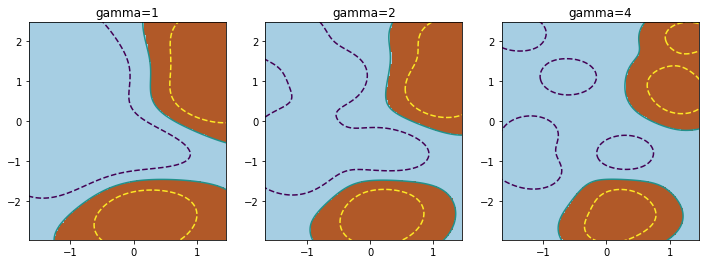

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4*len(gamma_option), 4))
for i, gamma in enumerate(gamma_option, 1):
    svm = SVC(kernel='rbf', gamma=gamma)
    svm.fit(X,Y)
    plt.subplot(1, len(gamma_option), i)
    plt.scatter(X[:,0], X[:,1], c=Y, zorder=10, cmap=plt.cm.Paired)
    plt.axis('tight')
    XX, YY = np.mgrid[-3:3:200j, -3:3:200j]
    Z = svm.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, color=['k','k','k'],
               linestyles=['--','-','--'], levels=[-.5, 0, .5])
    plt.title('gamma=%d'%gamma)
    
plt.show()

<br>
### **02 선형 커널 함수와 RBF 커널 함수의 비교**
1. RBF 방식의 커널이 항상 유용한 것은 아니듯, 선형이 유용한 경우도 존재한다
1. 시나리오1 : **Feacture** 갯수와 **Sample의** 갯수가 **모두 큰 경우** 계산량이 복잡하면 선형모델로 구분하는게 더 효과적이다
1. 시나리오2 : **Feacture** 갯수가 학습데이터 샘플 갯수보다 **훨씬 큰 경우** RBF는 Overfitting이 잘 일어나기 때문이다
1. 시나리오3 : Feacture 갯수보다 **학습데이터 샘플의 갯수가 훨씬 많은 경우**
1. 위의 3가지 경우가 아니라면 **RBF**를 사용하여 분석해보자

<br>
## **4 SVM을 활용한 News Topic 분류**
1. 뉴스그룹 20개의 데이터를 불러와서 정제작업을 진행한다
1. 분류모델은 **선셩회귀식**을 사용한다
1. **category 검정은** 반복문이 아닌 Sklearn의 **GridSearchCV를** 사용한다

<br>
### **01 SVC를 활용한 모델의 학습**

> **GridSearchCV()**

1. **데이터 분할, 폴드 생성, 교차학습 및 검증, 가장 효과적인 파라미터 추출등을** 함께 진행한다
1. **n_jobs = -1 :** 개별 코어들을 병렬로 진행한다
1. **cv = 3** : 3폴드 교차검증을 진행한다

In [54]:
# 학습할 데이터를 불러온다
categories = None
data_train = fetch_20newsgroups(subset='train', categories=categories, random_state=42)
data_test  = fetch_20newsgroups(subset='test', categories=categories, random_state=42)

# 데이터를 전처리 작업을 진행한다
cleaned_train = clean_text(data_train.data)
label_train   = data_train.target
cleaned_test  = clean_text(data_test.data)
label_test    = data_test.target

# Tf-IDF로 텍스트를 임베딩 작업 진행한다
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words='english', max_features=8000)
term_docs_train  = tfidf_vectorizer.fit_transform(cleaned_train)
term_docs_test   = tfidf_vectorizer.transform(cleaned_test)

In [32]:
# 텍스트 데이터를 분류하는 경우 선형함수를 사용한다
arameters  = {'C': [0.1, 1, 10, 100]}
svc_libsvm = SVC(kernel='linear')

# 전체 20개의 파라미터를 순차적 검증하기 위하여 for 반복문 대신에
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(svc_libsvm, parameters, n_jobs=-1, cv=3)

In [32]:
# 위에서 정의한 모델을 활용하여 학습을 진행한다
import timeit
start_time = timeit.default_timer()
grid_search.fit(term_docs_train, label_train)
print("--- %0.3fs seconds ---" % (timeit.default_timer() - start_time))
print(grid_search.best_params_)
print(grid_search.best_score_)

--- 329.416s seconds ---
{'C': 10}
0.8665370337634789


In [56]:
%time
# 최적화된 파라미터로 세팅된 SVM모델을 Test 한다
svc_libsvm_best = grid_search.best_estimator_
accuracy = svc_libsvm_best.score(term_docs_test, label_test)
print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

The accuracy on testing set is: 76.2%


<br>
### **02 SVC 모델의 튜닝 1**
> **LinearSVC()**

1. 원본 데이터세트를 활용하여 튜닝을 한다
1. sklearn에서 제공하는 **LinearSVC()** 모듈을 사용해보자
1. SVC와 유사하지만, **libsvm** 모듈 대신에, **liblinear** 를 기반으로 구성
1. 모델생성 속도측면에서 10배 이상 빠르다

In [57]:
# LinearSVC() 를 활용하여 분류모델을 생성한다
from sklearn.svm import LinearSVC
svc_linear = LinearSVC()
grid_search = GridSearchCV(svc_linear, parameters, n_jobs=-1, cv=3)

start_time = timeit.default_timer()
grid_search.fit(term_docs_train, label_train)
print("--- %0.3fs seconds ---" % (timeit.default_timer() - start_time))
print(grid_search.best_params_)
print(grid_search.best_score_)

--- 11.786s seconds ---
{'C': 1}
0.8707795651405339


In [58]:
# 생성한 모델의 성능을 비교평가한다
svc_linear_best = grid_search.best_estimator_
accuracy = svc_linear_best.score(term_docs_test, label_test)
print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

The accuracy on testing set is: 77.9%


<br>
### **03 SVC 모델의 튜닝 2**
> **Pipeline()**

1. Feacture 추출기를 **Pipeline API로** 교체한다
1. max_df : 문서빈도 중 최대값을 설정
1. max_feature : 중요하게 모델에서 학습 할 Feacture 수
1. sublinear_tf : 로그함수 또는 다른함수를 이용하여 출현빈도를 변환
1. smooth_idf : 용어의 출현 빈도에 대한 Smoothing 초기값
1. Grid 검색모델은 **파이프라인 전체에** 걸쳐서 **최적의 Setting을** 찾는다

In [59]:
# Tf-IDF 추출기와 SVM 분류기를 1개의 PipeLine로 묶는다
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svc', LinearSVC()), ])

In [60]:
# Pipe Line 단계의 이름과 파라미터를 묶어서 키로 설정한다
parameters_pipeline = {
    'tfidf__max_df': (0.25, 0.5),
    'tfidf__max_features': (40000, 50000),
    'tfidf__sublinear_tf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'svc__C': (0.1, 1, 10, 100),}

In [61]:
grid_search = GridSearchCV(pipeline, parameters_pipeline, n_jobs=-1, cv=3)
start_time  = timeit.default_timer()
grid_search.fit(cleaned_train, label_train)
print("--- %0.3fs seconds ---" % (timeit.default_timer() - start_time))
print(grid_search.best_params_)
print(grid_search.best_score_)

--- 468.816s seconds ---
{'svc__C': 1, 'tfidf__max_df': 0.5, 'tfidf__max_features': 40000, 'tfidf__smooth_idf': False, 'tfidf__sublinear_tf': True}
0.8883683931412409


In [62]:
pipeline_best = grid_search.best_estimator_
accuracy = pipeline_best.score(cleaned_test, label_test)
print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

The accuracy on testing set is: 80.6%


<br>
## **5 SVM을 활용한 심전도 데이터로 태아의 상태 분류**
1. 뉴스그룹 20개의 데이터를 불러와서 정제작업을 진행한다
1. 분류모델은 **선셩회귀식**을 사용한다
1. **category 검정은** 반복문이 아닌 Sklearn의 **GridSearchCV를** 사용한다

In [71]:
# 태아의 심전도 데이터 불러오기
import pandas as pd
df = pd.read_excel('./data/CTG.xls', 'Raw Data')
X  = df.iloc[1:2126, 3:-2].values
Y  = df.iloc[1:2126, -1].values

# 데이터 분포비율 분석
Counter(Y)

Counter({2.0: 295, 1.0: 1654, 3.0: 176})

In [73]:
# Test를 위해 20% 데이터를 분리한다
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=.2, random_state=42)

In [77]:
# RBF 기반 SVM모델을 튜닝한다
svc         = SVC(kernel='rbf')
parameters  = {'C':(100, 1e3, 1e4, 1e5),
               'gamma':(1e-8, 1e-7, 1e-6, 1e-5)}
grid_search = GridSearchCV(svc, parameters, n_jobs=-1, cv=3)
start_time  = timeit.default_timer()
grid_search.fit(X_train, Y_train)
print("--- %0.3fs seconds ---" % (timeit.default_timer() - start_time))
print(grid_search.best_params_)
print(grid_search.best_score_)

# 최적화된 모델의 파라미터를 출력
svc_best = grid_search.best_estimator_
svc_best

--- 6.878s seconds ---
{'C': 100000.0, 'gamma': 1e-07}
0.9447058823529412


SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-07, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [84]:
# 최적화 파라미터를 사용하여 모델을 Test 한다
accuracy = svc_best.score(X_test, Y_test)
print('The accuracy on testing set is: {0:.1f}%'.format(accuracy*100))

The accuracy on testing set is: 95.5%


In [87]:
# 개별 클래스멸 성능을 측정한다
prediction = svc_best.predict(X_test)#, Y_test)
report     = classification_report(Y_test,prediction)
print(report)

             precision    recall  f1-score   support

        1.0       0.96      0.98      0.97       324
        2.0       0.89      0.91      0.90        65
        3.0       1.00      0.78      0.88        36

avg / total       0.96      0.96      0.95       425

